# Compute Mode Connectivity Graphs

Notes

- The full pipeline includes:
    - train PINN models using 100 different random seeds
    - setup MC runs using `setup_MC_runs.ipynb` (this creates a file used by the `train_eval_pinn_multi.py`
    - submit MC runs using `train_eval_pinn_multi.py`
    - process MC runs and construct graphs using this notebook

<br>

- Results are strored in the following locations
    - individual checkpoints: 
    ```
    /global/cfs/cdirs/m636/geniesse/projects/characterizing-pinns-failure-modes/pbc_examples/checkpoints
    ```
    - curve checkpoints:
    ```
    /global/cfs/cdirs/m636/geniesse/projects/dnn-mode-connectivity/checkpoints_global
    ```


## imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import numpy as np
import pandas as pd
import networkx as nx
import scipy 

import matplotlib.pyplot as plt
import seaborn as sns

## Compute pairwise-connected graph

In [170]:
!ls checkpoints_global/PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_convection_beta_1.0_lr_1.0_seed_002

checkpoint-0.pt        checkpoint-0_curve.npz


In [171]:
# load pairs 
# pairs_file = "PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs.csv"
# pairs_file = "PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs.csv"

pairs_file = "PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs.csv"
df_pairs = pd.read_csv(pairs_file)

# assign curve name 
df_pairs = df_pairs.assign(
    curve_name=[f"{_.init_start}_{_.init_end}".replace(".pt","") for __,_ in df_pairs.iterrows()]
)

# assign result folder 
df_pairs = df_pairs.assign(
    result_file=[f"checkpoints_global/{_}/checkpoint-0_curve.npz" for _ in df_pairs.curve_name]
)

# assign result folder 
df_pairs = df_pairs.assign(
    checkpoint_file=[f"checkpoints_global/{_}/checkpoint-0.pt" for _ in df_pairs.curve_name]
)

# assign source,target values
df_pairs = df_pairs.assign(
    source=[int(_.split("_seed_")[-1].split(".pt")[0]) for _ in df_pairs.init_start],
    target=[int(_.split("_seed_")[-1].split(".pt")[0]) for _ in df_pairs.init_end]
)


# assign edge tuples
df_pairs = df_pairs.assign(
    edge=[_ for _ in zip(df_pairs.source.values, df_pairs.target.values)]
)

# show df
df_pairs

,init_start,init_end,curve_name,result_file,checkpoint_file,source,target,edge
0,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_002.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,2,"(1, 2)"
1,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_003.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,3,"(1, 3)"
2,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_004.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,4,"(1, 4)"
3,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_005.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,5,"(1, 5)"
4,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_006.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,6,"(1, 6)"
...,...,...,...,...,...,...,...,...
4945,PINN_convection_beta_1.0_lr_1.0_seed_097.pt,PINN_convection_beta_1.0_lr_1.0_seed_099.pt,PINN_convection_beta_1.0_lr_1.0_seed_097_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,97,99,"(97, 99)"
4946,PINN_convection_beta_1.0_lr_1.0_seed_097.pt,PINN_convection_beta_1.0_lr_1.0_seed_100.pt,PINN_convection_beta_1.0_lr_1.0_seed_097_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,97,100,"(97, 100)"
4947,PINN_convection_beta_1.0_lr_1.0_seed_098.pt,PINN_convection_beta_1.0_lr_1.0_seed_099.pt,PINN_convection_beta_1.0_lr_1.0_seed_098_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,98,99,"(98, 99)"
4948,PINN_convection_beta_1.0_lr_1.0_seed_098.pt,PINN_convection_beta_1.0_lr_1.0_seed_100.pt,PINN_convection_beta_1.0_lr_1.0_seed_098_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,checkpoints_global/PINN_convection_beta_1.0_lr...,98,100,"(98, 100)"


In [103]:
keep_nodes = 5

df_pairs = df_pairs[df_pairs.source.le(keep_nodes) & df_pairs.target.le(keep_nodes)]
df_pairs = df_pairs.reset_index(drop=True)
df_pairs

,init_start,init_end,curve_name,result_file,source,target,edge
0,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_002.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,2,"(1, 2)"
1,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_003.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,3,"(1, 3)"
2,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_004.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,4,"(1, 4)"
3,PINN_convection_beta_1.0_lr_1.0_seed_001.pt,PINN_convection_beta_1.0_lr_1.0_seed_005.pt,PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,1,5,"(1, 5)"
4,PINN_convection_beta_1.0_lr_1.0_seed_002.pt,PINN_convection_beta_1.0_lr_1.0_seed_003.pt,PINN_convection_beta_1.0_lr_1.0_seed_002_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,2,3,"(2, 3)"
5,PINN_convection_beta_1.0_lr_1.0_seed_002.pt,PINN_convection_beta_1.0_lr_1.0_seed_004.pt,PINN_convection_beta_1.0_lr_1.0_seed_002_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,2,4,"(2, 4)"
6,PINN_convection_beta_1.0_lr_1.0_seed_002.pt,PINN_convection_beta_1.0_lr_1.0_seed_005.pt,PINN_convection_beta_1.0_lr_1.0_seed_002_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,2,5,"(2, 5)"
7,PINN_convection_beta_1.0_lr_1.0_seed_003.pt,PINN_convection_beta_1.0_lr_1.0_seed_004.pt,PINN_convection_beta_1.0_lr_1.0_seed_003_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,3,4,"(3, 4)"
8,PINN_convection_beta_1.0_lr_1.0_seed_003.pt,PINN_convection_beta_1.0_lr_1.0_seed_005.pt,PINN_convection_beta_1.0_lr_1.0_seed_003_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,3,5,"(3, 5)"
9,PINN_convection_beta_1.0_lr_1.0_seed_004.pt,PINN_convection_beta_1.0_lr_1.0_seed_005.pt,PINN_convection_beta_1.0_lr_1.0_seed_004_PINN_...,checkpoints_global/PINN_convection_beta_1.0_lr...,4,5,"(4, 5)"


### Pseudo code computing CKA similarity between curve model outputs

```python

# TODO: need to load CurveNetPINN (see train_eval_pinn_multi.py)
model = CurveNetPINN(
    # num_classes, # TODO: we don't need this anymore ...
    curve,
    architecture.curve,
    args.num_bends,
    args.fix_start,
    args.fix_end,
    architecture_kwargs=architecture.kwargs,
)
pinn_model.dnn = copy.deepcopy(model)


# load checkpoint and evaluate CKA
u_preds = []

# loop over edges 
for index, df_pair in df_pairs.iterrows():

    # extract curve metrics for the edge pair
    checkpoint = torch.load(df_pair.checkpoint_file)
    pinn_model.dnn.load_state_dict(checkpoint)
     
    # loop over points on the curve
    for t in [0, 2, 4]: 
        u_pred = pinn_model.predict(x, coeff_t=t)
        u_preds.append(u_pred)
    
# compute CKA similarity
cka_scores = []
for u_pred_1 in u_preds:
    for u_pred_2 in u_preds:
        cka_score = linear_CKA(u_pred_1, u_pred_2)
        cka_scores.append(cka_score)
      
```

### Construct graph and add mode connected point between each edge

In [166]:
# initialize graph based on edges
edges = df_pairs.edge.to_list()
G1 = nx.Graph(edges)

# construct new graph (with extra nodes)
G2 = nx.Graph()

# loop over edges 
for index, df_pair in df_pairs.iterrows():

    # extract curve metrics for the edge pair
    with np.load(df_pair.result_file) as result:
        # mc = float(result['mc_metric'])
        curve_losses = result['tr_error_u_rel']
        # curve_losses = result['tr_loss']
    
    # assign node id to the new node
    curve_node = len(G1) + index + 1
    source_node = df_pair.source
    target_node = df_pair.target
    # curve_node = f"{df_pair.source}_{df_pair.target}"
    # source_node = f"{df_pair.source}"
    # target_node = f"{df_pair.target}"
    
    # assign node data
    # if source_node not in G2.nodes:
    G2.add_node(source_node, loss=curve_losses[0])
    # G2.add_node(curve_node, loss=np.max(curve_losses))
    # G2.add_node(curve_node, loss=np.max(curve_losses[1:-1]))
    G2.add_node(curve_node, loss=curve_losses[np.argmax(np.abs(curve_losses))])
    # if target_node not in G2.nodes:
    G2.add_node(target_node, loss=curve_losses[-1])

    # add new path going through the curve node
    nx.add_path(G2, [source_node, curve_node, target_node])
    # print(f"[+] ({source_node}, {curve_node}, {target_node})")
    print(f"[+] ({source_node}, {curve_node:2d}, {target_node}) => ({G2.nodes[source_node]['loss']:.6f}, {G2.nodes[curve_node]['loss']:.6f}, {G2.nodes[target_node]['loss']:.6f})")

# show some things
print(f"{G1.number_of_nodes()=}")
print(f"{G1.number_of_edges()=}")
print(f"{G2.number_of_nodes()=}")
print(f"{G2.number_of_edges()=}")

[+] (1,  6, 2) => (0.004980, 0.793539, 0.003480)
[+] (1,  7, 3) => (0.004980, 0.577572, 0.008653)
[+] (1,  8, 4) => (0.004980, 0.634498, 0.006271)
[+] (1,  9, 5) => (0.004980, 1.785592, 0.004480)
[+] (2, 10, 3) => (0.003480, 1.381099, 0.008653)
[+] (2, 11, 4) => (0.003480, 0.770714, 0.006271)
[+] (2, 12, 5) => (0.003480, 2.831908, 0.004480)
[+] (3, 13, 4) => (0.008653, 1.187149, 0.006271)
[+] (3, 14, 5) => (0.008653, 1.624488, 0.004480)
[+] (4, 15, 5) => (0.006271, 1.821436, 0.004480)
G1.number_of_nodes()=5
G1.number_of_edges()=10
G2.number_of_nodes()=15
G2.number_of_edges()=20


In [144]:
curve_losses

array([0.00627137, 0.49663333, 1.82143625, 1.43099241, 0.00448025])

In [145]:
# TODO: double check this
#       sorting for now, but make sure these match nodes in unstructured grid
#       alternative is to just use the order the node was added to the Graph
#       but not sure how to test this yet...


# compute array of node loss values
#loss_values = np.array([G2.nodes[_]['loss'] for _ in G2.nodes])
loss_values = np.array([G2.nodes[_]['loss'] for _ in sorted(G2.nodes)])

# TODO: testing
loss_values = np.array(list(nx.get_node_attributes(G2, 'loss').values()))
loss_values
nx.get_node_attributes(G2, 'loss')

{1: 0.004979682436311211,
 6: 0.7935390548541932,
 2: 0.0034801871202968277,
 7: 0.5775719287780742,
 3: 0.008652932080179143,
 8: 0.6344978953879774,
 4: 0.006271368574068963,
 9: 1.785592489936389,
 5: 0.004480246535353288,
 10: 1.381098700063303,
 11: 0.7707142228050365,
 12: 2.8319083874316875,
 13: 1.187149394727312,
 14: 1.6244882998452521,
 15: 1.8214362520140717}

In [146]:
# TODO: double check this
#       sorting for now, but make sure these match nodes in unstructured grid
#       alternative is to just use the order the node was added to the Graph
#       but not sure how to test this yet...

# compute node embedding (dummy for now)
embedding_dict = nx.spring_layout(G2, iterations=50, weight='loss')
# embedding_dict = nx.circular_layout(G2)
# embedding_dict = nx.random_layout(G2)

# reformat as an array
#embedding = np.vstack([embedding_dict[_] for _ in G2.nodes])
embedding = np.vstack([embedding_dict[_] for _ in sorted(G2.nodes)])

# TODO: testing
embedding = np.vstack([embedding_dict[_] for _ in embedding_dict])


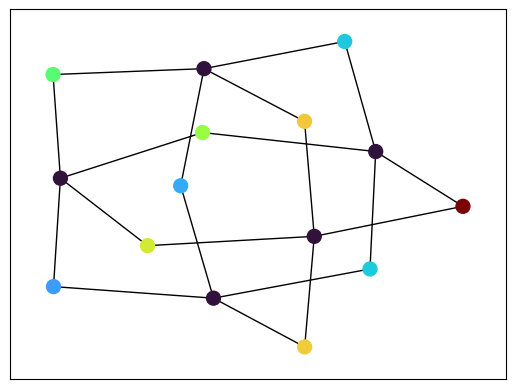

In [147]:
# quick look at the network 
nx.draw_networkx(G2, pos=embedding_dict, node_color=loss_values, cmap="turbo", node_size=100,  with_labels = False)

### Compute merge tree, etc.

In [148]:
# lines_unique = list(G2.edges())
# lines_unique

In [156]:
# TODO: should we use list or array?
# extract the undirected edges as an array
lines_unique = list(G2.edges())
print(f"{lines_unique=}")

# count the number of unique lines
n_lines = len(lines_unique)
print(f"{n_lines=}")

# define points that belong in each line
conn = np.ravel(lines_unique)
print(f"{conn=}")

# define offset of last vertex of each element
offsets = (np.arange(n_lines) + 1) * 2
print(f"{offsets=}")

# define array that defines the cell type of each element in the grid
# cell_types = np.repeat(VtkLine.tid, n_lines)
# print(f"{cell_types=}")

# define dictionary with variables associated to each verte
print(f"{loss_values=}")


lines_unique=[(1, 6), (1, 7), (1, 8), (1, 9), (6, 2), (2, 10), (2, 11), (2, 12), (7, 3), (3, 10), (3, 13), (3, 14), (8, 4), (4, 11), (4, 13), (4, 15), (9, 5), (5, 12), (5, 14), (5, 15)]
n_lines=20
conn=array([ 1,  6,  1,  7,  1,  8,  1,  9,  6,  2,  2, 10,  2, 11,  2, 12,  7,
        3,  3, 10,  3, 13,  3, 14,  8,  4,  4, 11,  4, 13,  4, 15,  9,  5,
        5, 12,  5, 14,  5, 15])
offsets=array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40])
loss_values=array([0.00497968, 0.79353905, 0.00348019, 0.57757193, 0.00865293,
       0.6344979 , 0.00627137, 1.78559249, 0.00448025, 1.3810987 ,
       0.77071422, 2.83190839, 1.18714939, 1.6244883 , 1.82143625])


In [181]:
import sys
sys.path.append("./code")
from ttk_functions import compute_merge_tree
from ttk_functions import compute_merge_tree_planar
from ttk_functions import compute_persistence_barcode
from ttk_functions import compute_aknn
from ttk_functions import visualize_merge_tree
from ttk_functions import visualize_merge_tree_planar


# format output path
output_path = f"paraview_files/{pairs_file.replace('.csv','')}_keep_nodes_{keep_nodes}"
print(output_path)


# compute merge tree
merge_tree = compute_merge_tree(
	loss_landscape=None, loss_coords=None, loss_values=loss_values, loss_graph=G2, 
    embedding=embedding, output_path=output_path, vtk_format='vtu',
    graph_kwargs='LossGraph', n_neighbors=None,
	persistence_threshold=0.0, threshold_is_absolute=False)


# merge_tree_planar = compute_merge_tree_planar(
# 	loss_landscape=None, loss_coords=None, loss_values=loss_values, loss_graph=G2, 
#     embedding=embedding, output_path=output_path, vtk_format='vtu',
#     graph_kwargs='LossGraph', n_neighbors=None,
# 	persistence_threshold=0.0, threshold_is_absolute=False)



paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_keep_nodes_5
point_data={'Loss': array([0.00497968, 0.79353905, 0.00348019, 0.57757193, 0.00865293,
       0.6344979 , 0.00627137, 1.78559249, 0.00448025, 1.3810987 ,
       0.77071422, 2.83190839, 1.18714939, 1.6244883 , 1.82143625])}
stdout: [Common]                            ▒▒▒▒▒▒▒▒▒▒▒▒▒▒░
[Common]                     ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░
[Common]                 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
[Common]              ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░▒░░░▒▒░░░▒▒▒▒▒▒▒
[Common]           ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░   ░░░░░░░░░░░▒▒▒▒▒▒▒
[Common]         ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░                    ░░░░░░░▒▒▒
[Common]       ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░    ▒▒▒▒▒▒▒▒▒▒▒▒          ░▒▒ ░░▒▒▒
[Common]      ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░   ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░▒▒       ░░▒ ░░▒▒
[Common]     ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░  ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░▒▒    ░░░░▒ ░░▒▒
[Common]    ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░ ▒▒▒▒▒▒▒▒▒▒▒▒▄▓██▓█████▓▄▄░░░▒   ░░░░░░░░░▒
[Common]   

In [183]:
!ls paraview_files/*

paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_UnstructuredGrid_LossGraph.vtu
paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_UnstructuredGrid_LossGraph_PersistenceThreshold_0.1_ThresholdIsAbsolute_0_MergeTree.csv
paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_UnstructuredGrid_LossGraph_PersistenceThreshold_0.1_ThresholdIsAbsolute_0_MergeTree_edge.csv
paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_UnstructuredGrid_LossGraph_PersistenceThreshold_0.1_ThresholdIsAbsolute_0_MergeTree_segmentation.csv
paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_keep_nodes_5_UnstructuredGrid_LossGraph.vtu
paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_keep_nodes_5_UnstructuredGrid_LossGraph_PersistenceThreshold_0.0_ThresholdIsAbsolute_0_MergeTree.csv
paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_keep_nodes_5_UnstructuredGrid_LossGraph_PersistenceThreshold_0.0_ThresholdIsAbsolute_0_

In [185]:
!cat paraview_files/PINN_convection_beta_1.0_lr_1.0_n_seeds_100_pairs_keep_nodes_5_UnstructuredGrid_LossGraph_PersistenceThreshold_0.0_ThresholdIsAbsolute_0_MergeTree.csv

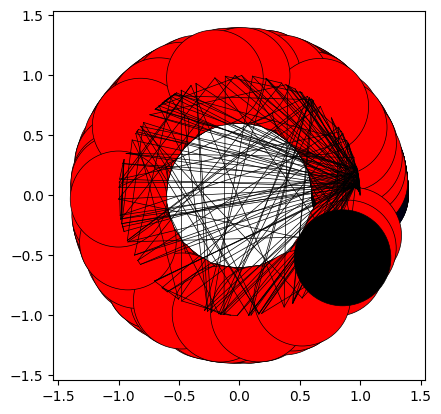

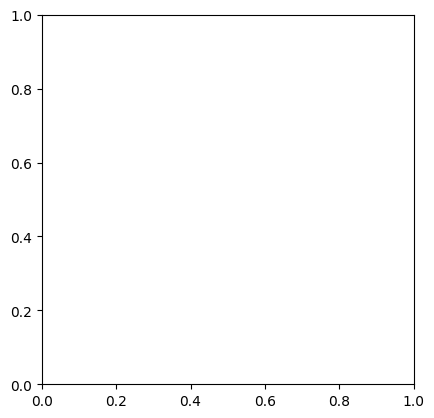

In [153]:
from ttk_functions import visualize_merge_tree_planar

visualize_merge_tree("/../paraview_files/")

In [ ]:
visualize_merge_tree_planar("/../paraview_files/")

## Compute k-nearest neighbor graph [TODO]

TODO:
- [ ] load in each model, one-by-one
- [ ] for each model, compute distance to every other model
- [ ] compute k-neighbor adjacency based on distances
- [ ] construct graph and assign loss values (same as above)